# An Introduction to "Consisten Bayesian" Inversion 

## Example 1: The basics and a comparison to statistical Bayesian inference

This tutorial introduces the basic ideas presented in 

_[***Combining Push-Forward Measures and Bayes' Rule to Construct Consistent Solutions to Stochastic Inverse Problems
***, T. Butler, J. Jakeman, T. Wildey, SIAM J. Sci. Comput., 40(2), A984–A1011](https://epubs.siam.org/doi/abs/10.1137/16M1087229)_

## Libraries

 * We make use of `numpy` to handle the sample sets defined as arrays, and we also use the `random` subpackage within `numpy` to generate random samples of various distributions.
 
 
 * We use a standard kernel densitmator in `scipy.stats` to approximate the densities on sample sets.
 
 
 * We use `matplotlib.pyplot` to visualize results.

In [1]:
# The libraries we will use
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm # The standard Normal distribution
from scipy.stats import gaussian_kde as GKDE # A standard kernel density estimator

## The big (and fuzzy) picture

### Defining the input/output spaces and the mapping between them

 * Let $\lambda\in\Lambda$ denote the inputs to some model, which we refer to as the model parameters.
 
 
 * The measurable (scalar) outputs of the model are referred to as quantities of interest (QoI), and denoted by $Q(\lambda)$ to make the dependence on the parameters explicit.
 
 
 * Let $\mathcal{D} = Q(\Lambda)$ denote the range of observable data that can be predicted by the model.

### This example:

 * $\Lambda=[-1,1]$ (this is dealt with implicitly later).
 
 
 * $Q(\lambda) = \lambda^p$ for $p=1$ or $5$
 
 
 * $\mathcal{D} = Q(\Lambda) = [-1,1]$ (we will explore the impacts of this later).

In [2]:
def QoI(lam,p): # defing a QoI mapping function
    q = lam**p
    return q

### The inverse problem

Given a probability measure on $Q(\lambda)$ describing the uncertainty in observed data, determine a probability measure $P_\Lambda$ on $\Lambda$ that is ***consistent*** with both the model and observed data. 

### Consistent?

By consistent, we mean the push-forward measure of $P_\Lambda$ through the QoI map $Q(\lambda)$ matches the probability measure given on $Q(\lambda)$. 

In other words, we want $P_\Lambda$ to be a ***pullback measure.***

## Constructing a pullback measure in terms of a density.

We first take an inventory of common "ingredients" used to formulate an inverse problem.


 * $\pi_{\Lambda}^{prior}$ is a density representing any prior knowledge on the relative likelihoods of parameters.
 
 
 * $\pi_{\mathcal{D}}^{obs}$ is a density describing the relative likelihoods of model outputs defining the observed data.
 

To construct the pullback density, we utilize the ***push-forward of the prior***:

 
 * $\pi_{\mathcal{D}}^{Q(prior)}$ is the push-forward of the prior density and represents how the prior knowledge of relative likelihoods of parameter values defines a relative likelihood of model outputs.
 

A pullback measure, which we refer to as a posterior measure, is then represented as a density in the form

$$
  \large \pi_\Lambda^{post}(\lambda) = \pi_\Lambda^{prior}(\lambda) \frac{\pi_{\mathcal{D}}^{obs}(Q(\lambda))}{\pi_{\mathcal{D}}^{Q(prior)}(Q(\lambda))}. 
$$

## Some important notes

 * Since the push-forward of the prior appears in the denominator, we make the following ***predictability assumption*** to ensure this form of the posterior always has meaning:
 > There exists a constant $C>0$ such that $\pi_{\mathcal{D}}^{obs}(q) \leq C\pi_{\mathcal{D}}^{Q(prior)}(q)$ for a.e. $q\in\mathcal{D}$.
 
 
 * This form of the posterior is ***stable*** (in the total-variation metric) with respect to perturbations in the prior and observed densities.
 
 
 * Since the prior and observed densities are assumed given, the ***construction of the posterior is reduced to constructing the push-forward of the prior***. In other words, solving a forward problem to obtain $\pi_{\mathcal{D}}^{Q(prior)}$ provides the necessary and sufficient information required to uniquely define the posterior.
 
 
 * In practice, we numerically approximate $\pi_{\mathcal{D}}^{Q(prior)}$ by generating a set of i.i.d. samples from the prior, evaluating the QoI map on this sample set, and then applying density estimation to this subsequent QoI sample set. 


 * We prove that the error in the approximate posterior defined by this approximate push-forward of the prior is bounded by the error in the approximate push-forward, i.e., this process is numerically stable. 

### This example:

 * $\pi_{\Lambda}^{prior} \sim U([-1,1])$
 
 
 * $\pi_{\mathcal{D}}^{obs} \sim N(0.25,0.1^2)$
 
 
 * We construct $\pi_{\mathcal{D}}^{Q(prior)}$ for the two different QoI maps $\lambda^p$ ($p=1$ or $5$) using `N` samples and the Gaussian Kernel Density Estimator (`GKDE`) imported from `scipy.stats`.

In [3]:
# Compute the pushforward of the prior

N = int(1E4) # number of samples from prior
lam = np.random.uniform(low=-1,high=1,size=N) # sample set of the prior

# Evaluate the two different QoI maps on this prior sample set
qvals_linear = QoI(lam,1) # Evaluate lam^1 samples
qvals_nonlinear = QoI(lam,5) # Evaluate lam^5 samples

# Estimate push-forward densities for each QoI
q_linear_kde = GKDE( qvals_linear ) 
q_nonlinear_kde = GKDE( qvals_nonlinear )

In [4]:
# Evaluate the observed density on the QoI sample set
obs_vals_linear = norm.pdf(qvals_linear, loc=0.25, scale=0.1)
obs_vals_nonlinear = norm.pdf(qvals_nonlinear, loc=0.25, scale=0.1)

## Sampling the posterior with rejection sampling

A simple [accept/reject sampling](https://en.wikipedia.org/wiki/Rejection_sampling) scheme can be applied to the same set of prior samples used in constructing the approximate push-forward density to generate a set of i.i.d. samples of the posterior. 

We do this by vectorizing a simple [accept/reject algorithm](https://en.wikipedia.org/wiki/Rejection_sampling#Algorithm) that we summarize below.

Using the notation in the Wiki article, suppose we have samples from a random variable with density $g$, but we want to sample from a random variable with density $f$. 

We can perform accept/reject sampling if there exists $M>0$ such that $f(x)\leq M g(x)$ for all $x$. 

Given this $M$, and a proposed sample $y$ from the random variable with density $g$, we check to see if we should accept $y$ as being a sample from the random variable with density $f$ as follows:

 * Generate uniform random sample $u\sim U(0,1)$.
 
 
 * If $u < \frac{f(y)}{Mg(y)}$, then accept $y$, otherwise reject $y$ as coming from the random variable with density $f$.
 
## Connecting rejection sampling to our posterior

The $g$ in our case is the prior and the $f$ is the posterior, so if we can perform accept/reject sampling by proposing samples from the prior, then there exists $M>0$ such that

$$
    \pi_\Lambda^{prior}(\lambda) \frac{\pi_{\mathcal{D}}^{obs}(Q(\lambda))}{\pi_{\mathcal{D}}^{Q(prior)}(Q(\lambda))} \leq M \pi_\Lambda^{prior}(\lambda).
$$

Dividing through by the prior and multiplying by the push-forward of the prior to both sides, we see that the ability to perform accept/reject sampling is guaranteed if there exists an $M$ such that

$$
    \pi_{\mathcal{D}}^{obs}(Q(\lambda)) \leq M \pi_{\mathcal{D}}^{Q(prior)},
$$

which is ***exactly the predictability assumption***.

Moreover, by viewing the ratio

$$
    r(Q(\lambda)) := \frac{\pi_{\mathcal{D}}^{obs}(Q(\lambda))}{\pi_{\mathcal{D}}^{Q(prior)}(Q(\lambda))}
$$

as simply defining a re-weighting of the prior samples, we see that we can estimate $M$ by the maximum of $r(Q(\lambda))$ on the sample set of the prior. 
Then, by comparing $r(Q(\lambda))/M$ to uniform random variables, we can accept or reject a particular $\lambda$ sample generated from the prior.

In [5]:
def rejection_sampling(r):
    # Perform accept/reject sampling on a set of proposal samples using
    # the weights r associated with the set of samples and return
    # the indices idx of the proposal sample set that are accepted.
    N = r.size # size of proposal sample set
    check = np.random.uniform(low=0,high=1,size=N) # create random uniform weights to check r against
    M = np.max(r)
    new_r = r/M # normalize weights 
    idx = np.where(new_r>=check)[0] # rejection criterion
    return idx

In [6]:
# Sample from the CBayes posterior
r_linear = np.divide(obs_vals_linear,q_linear_kde(qvals_linear))
r_nonlinear = np.divide(obs_vals_nonlinear,q_nonlinear_kde(qvals_nonlinear))
    
samples_to_keep_linear = rejection_sampling(r_linear)
post_q_linear = qvals_linear[samples_to_keep_linear]
post_lam_linear = lam[samples_to_keep_linear]

samples_to_keep_nonlinear = rejection_sampling(r_nonlinear)
post_q_nonlinear = qvals_nonlinear[samples_to_keep_nonlinear]
post_lam_nonlinear = lam[samples_to_keep_nonlinear]

## Some diagonistics

In some cases, like in the linear QoI map, we have a good idea what the mean and standard deviation of the posterior should be, which are easily estimated and verified using the accepted sample set. 
In essentially every case we can check if the statistics on the push-forward of the posterior are reasonable by computing statistics of the `post_q_*` samples.
But, statistics just tell part of the story, and we should in general check at least two things:

 1. Did we satisfy the predictability assumption?
 
 2. What did we gain by solving the inverse problem?

Assuming the predictability assumption holds, then the posterior we construct is an actual density and ***should*** integrate to 1, i.e., $I(\pi_\Lambda^{post})=1$ where $I$ is the "integrate" function given by, 

$$
    I(\pi_\Lambda^{post}) = \int_\Lambda \pi_\Lambda^{post}(\lambda)\, d\mu_\Lambda.
$$

Then, by direct substitution, 

$$
    I(\pi_\Lambda^{post}) = \int_\Lambda \pi_\Lambda^{prior}(\lambda)r(Q(\lambda))\, d\mu_\Lambda = \int_\Lambda r(Q(\lambda))\, dP_\Lambda^{prior} = \mathbb{E}(r(Q(\lambda))).
$$

***Thus, if the sample mean of $r(Q(\lambda))$ is approximately 1, then we have numerically verified that the predictability assumption holds.*** (We will check this value below and investigate it more closely later for values that fall below 0.9.)

The ***information gain*** is often quantified by the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) (KL divergence) of the posterior with respect to the prior, which is given by

$$
    KL(\pi_{\Lambda}^{post} \, : \, \pi_{\Lambda}^{prior}) = \int_\Lambda \pi_\Lambda^{post}(\lambda)\log\left(\frac{\pi_\Lambda^{post}(\lambda)}{\pi_\Lambda^{prior}(\lambda)}\right)\, d\mu_\Lambda = \int_\Lambda r(Q(\lambda))\log r(Q(\lambda))\, dP_\Lambda^{prior}.
$$

The KL divergence is greater than or equal to 0, with larger values indicating that the posterior differs more significantly from the prior. 
We note that choosing different priors or different QoI maps clearly can impact the KL divergence.

In [7]:
print(np.mean(post_q_linear))
print(np.sqrt(np.var(post_q_linear)))
print(np.mean(r_linear))
print(np.mean(r_linear*np.log(r_linear)))

0.24950923153
0.0985991988625
1.00375418633
1.60102816929


In [8]:
print(np.mean(post_q_nonlinear))
print(np.sqrt(np.var(post_q_nonlinear)))
print(np.mean(r_nonlinear))
print(np.mean(r_nonlinear*np.log(r_nonlinear)))

0.259246627095
0.0981870190045
0.929468385308
1.81846286988


## Comparison to the statistical Bayesian posterior

The traditional formulation of a posterior density is of a conditional density of the form

$$
    \tilde{\pi}_\Lambda^{post}(\lambda \, | \, q) = \pi_\Lambda^{prior}\frac{ L(q\, |\,  \lambda) }{C}
$$

where $\pi_\Lambda^{prior}$ is the same prior used in our formulation, but

 * $L(q\, | \, \lambda)$ is a ***data likelihood*** function that is not necessarily the same as the observed density.
 
 
 * $C$ is a normalizing constant that is usually not important when generating samples from the posterior. We must compute it to compare to our posterior.
 

Fundamentally, a statistical Bayesian posterior is solving a different problem (parameter identification under uncertainty) formulated under different assumptions.
Below, we consider the same prior and QoI maps as before, and we make the data likelihood function match the observed density.

In [9]:
# compute normalizing constants
C_linear = np.mean(obs_vals_linear) 
C_nonlinear = np.mean(obs_vals_nonlinear)

sbayes_r_linear = obs_vals_linear/C_linear
sbayes_r_nonlinear = obs_vals_nonlinear/C_nonlinear

sbayes_samples_to_keep_linear = rejection_sampling(sbayes_r_linear)
sbayes_post_q_linear = qvals_linear[sbayes_samples_to_keep_linear]
sbayes_post_lam_linear = lam[sbayes_samples_to_keep_linear]


sbayes_samples_to_keep_nonlinear = rejection_sampling(sbayes_r_nonlinear)
sbayes_post_q_nonlinear = qvals_nonlinear[sbayes_samples_to_keep_nonlinear]
sbayes_post_lam_nonlinear = lam[sbayes_samples_to_keep_nonlinear]

### Note about plot generated below:

 * The push-forward of the prior is not quite constant over $\mathcal{D}=[-1,1]$ due to the use of the KDE, but it is effectively constant over the support of the observed density.

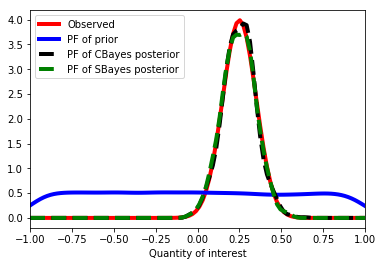

In [10]:
# Compare the observed and the pushforwards of prior, Cbayes posterior and Sbayes posterior
qplot = np.linspace(-1,1, num=100)
plt.clf()

# for plotting, we use the analytical push-forward since it is just a constant 
# otherwise, the ends are curved which could be fixed but not worth the effort
obs_vals_plot = norm.pdf(qplot, loc=0.25, scale=0.1)

postq_lin_kde = GKDE( post_q_linear )
sb_postq_lin_kde = GKDE( sbayes_post_q_linear )

oplot = plt.plot(qplot,obs_vals_plot, 'r-', linewidth=4, label="Observed")
prplot = plt.plot(qplot,q_linear_kde(qplot),'b-', linewidth=4, label="PF of prior")
poplot = plt.plot(qplot,postq_lin_kde(qplot),'k--', linewidth=4, label="PF of CBayes posterior")
sb_poplot = plt.plot(qplot,sb_postq_lin_kde(qplot),'g--', linewidth=4, label="PF of SBayes posterior")

plt.xlim([-1,1])
plt.xlabel("Quantity of interest")
plt.legend()
plt.show()

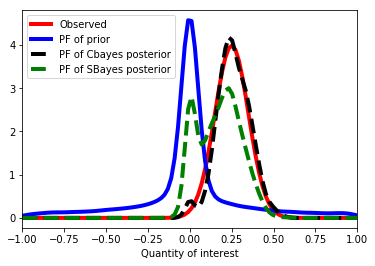

In [11]:
# Compare the observed and the pushforwards of prior, Cbayes posterior and Sbayes posterior
qplot = np.linspace(-1,1, num=100)
plt.clf()

obs_vals_plot = norm.pdf(qplot, loc=0.25, scale=0.1)
postq_nl_kde = GKDE( post_q_nonlinear )
sb_postq_nl_kde = GKDE( sbayes_post_q_nonlinear )

oplot = plt.plot(qplot,obs_vals_plot, 'r-', linewidth=4, label="Observed")
prplot = plt.plot(qplot,q_nonlinear_kde(qplot),'b-', linewidth=4, label="PF of prior")
poplot = plt.plot(qplot,postq_nl_kde(qplot),'k--', linewidth=4, label="PF of Cbayes posterior")
sb_poplot = plt.plot(qplot,sb_postq_nl_kde(qplot),'g--', linewidth=4, label="PF of SBayes posterior")


plt.xlim([-1,1])

plt.xlabel("Quantity of interest")
plt.legend()
plt.show()

### Investigating different observed densities

Once the push-forward of the prior, $\pi_\mathcal{D}^{Q(prior)}$, is constructed, the posterior for any observed density is trivially defined ***as long as the predictability assumption still holds.*** 

### For the observed densities below, use the predictability assumption to explain why one of these is labeled as `_good` and the other as `_bad`.

In [12]:
obs_vals_nonlinear_good = norm.pdf(qvals_nonlinear, loc=0.0, scale=0.1)
obs_vals_nonlinear_bad  = norm.pdf(qvals_nonlinear, loc=1.0, scale=0.1)

### Below, we investigate what should be good and bad. Some results may surprise you.

In [13]:
r_nonlinear_good = np.divide(obs_vals_nonlinear_good,q_nonlinear_kde(qvals_nonlinear))
r_nonlinear_bad = np.divide(obs_vals_nonlinear_bad,q_nonlinear_kde(qvals_nonlinear))

samples_to_keep_nonlinear_good = rejection_sampling(r_nonlinear_good)
post_q_nonlinear_good = qvals_nonlinear[samples_to_keep_nonlinear_good]
post_lam_nonlinear_good = lam[samples_to_keep_nonlinear_good]

samples_to_keep_nonlinear_bad = rejection_sampling(r_nonlinear_bad)
post_q_nonlinear_bad = qvals_nonlinear[samples_to_keep_nonlinear_bad]
post_lam_nonlinear_bad = lam[samples_to_keep_nonlinear_bad]

### The `_bad` results may not seem so surprising.

In [14]:
print(np.mean(post_q_nonlinear_bad))
print(np.sqrt(np.var(post_q_nonlinear_bad)))
print(np.mean(r_nonlinear_bad))
print(np.mean(r_nonlinear_bad*np.log(r_nonlinear_bad)))

0.934339171051
0.0507360178246
0.608887375609
2.0466421623


### But, these `_good` results are not as "good" as before in terms of the expected value of $r(Q(\lambda))$.

In [15]:
print(np.mean(post_q_nonlinear_good))
print(np.sqrt(np.var(post_q_nonlinear_good)))
print(np.mean(r_nonlinear_good))
print(np.mean(r_nonlinear_good*np.log(r_nonlinear_good)))

-0.000706168387815
0.0976226539227
0.867323148639
0.157829856918


### What do the plots tell us?

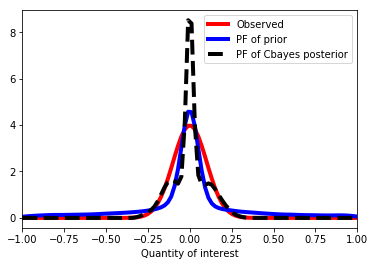

In [16]:
# Compare the observed and the pushforwards of prior and Cbayes posterior
qplot = np.linspace(-1,1, num=100)
plt.clf()

obs_vals_plot = norm.pdf(qplot, loc=0, scale=0.1)
postq_nl_kde = GKDE( post_q_nonlinear_good )


oplot = plt.plot(qplot,obs_vals_plot, 'r-', linewidth=4, label="Observed")
prplot = plt.plot(qplot,q_nonlinear_kde(qplot),'b-', linewidth=4, label="PF of prior")
poplot = plt.plot(qplot,postq_nl_kde(qplot),'k--', linewidth=4, label="PF of Cbayes posterior")

plt.xlim([-1,1])

plt.xlabel("Quantity of interest")
plt.legend()
plt.show()

### The problem lies in the approximation of the push-forward of the prior.

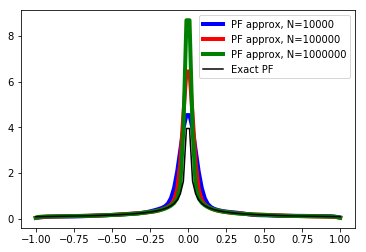

In [17]:
# Compute the pushforward of the prior for different sample sizes
qplot = np.linspace(-1,1, num=100)

Ns = [1E4, 1E5, 1E6]
cs = ['b','r','g']

for N,c in zip(Ns,cs):
    lam1 = np.random.uniform(low=-1,high=1,size=int(N)) # sample set of the prior

    qvals_nonlinear1 = QoI(lam1,5) # Evaluate lam^5 samples
 
    q_nonlinear_kde1 = GKDE( qvals_nonlinear1 )
    
    var = "PF approx, N=" + str(int(N))
    plt.plot(qplot,q_nonlinear_kde1(qplot),c, linewidth=4, label=var)

# There is an exact pdf of the push-forward
plt.plot(qplot, 1/10*np.abs(qplot)**(-4/5),'k',label='Exact PF')    
    
plt.legend()
plt.show()

### What happens when we use the exact push-forward?

In [18]:
r_nonlinear_good = np.divide(obs_vals_nonlinear_good,1/10*np.abs(qvals_nonlinear)**(-4/5))
r_nonlinear_bad = np.divide(obs_vals_nonlinear_bad,1/10*np.abs(qvals_nonlinear)**(-4/5))

samples_to_keep_nonlinear_good = rejection_sampling(r_nonlinear_good)
post_q_nonlinear_good = qvals_nonlinear[samples_to_keep_nonlinear_good]
post_lam_nonlinear_good = lam[samples_to_keep_nonlinear_good]

samples_to_keep_nonlinear_bad = rejection_sampling(r_nonlinear_bad)
post_q_nonlinear_bad = qvals_nonlinear[samples_to_keep_nonlinear_bad]
post_lam_nonlinear_bad = lam[samples_to_keep_nonlinear_bad]

In [19]:
print(np.mean(post_q_nonlinear_bad))
print(np.sqrt(np.var(post_q_nonlinear_bad)))
print(np.mean(r_nonlinear_bad))
print(np.mean(r_nonlinear_bad*np.log(r_nonlinear_bad)))

0.930201226096
0.0519985212715
0.531712309323
1.68580320212


In [20]:
print(np.mean(post_q_nonlinear_good))
print(np.sqrt(np.var(post_q_nonlinear_good)))
print(np.mean(r_nonlinear_good))
print(np.mean(r_nonlinear_good*np.log(r_nonlinear_good)))

-0.00509205894163
0.0997630045984
0.985265585901
0.820226899784


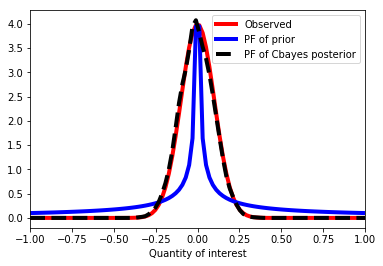

In [21]:
# Compare the observed and the pushforwards of prior and Cbayes posterior
qplot = np.linspace(-1,1, num=100)
plt.clf()

obs_vals_plot = norm.pdf(qplot, loc=0, scale=0.1)
postq_nl_kde = GKDE( post_q_nonlinear_good )


oplot = plt.plot(qplot,obs_vals_plot, 'r-', linewidth=4, label="Observed")
prplot = plt.plot(qplot,1/10*np.abs(qplot)**(-4/5),'b-', linewidth=4, label="PF of prior")
poplot = plt.plot(qplot,postq_nl_kde(qplot),'k--', linewidth=4, label="PF of Cbayes posterior")

plt.xlim([-1,1])

plt.xlabel("Quantity of interest")
plt.legend()
plt.show()